Test MSE: 2181676007424.0000, MAE: 743410.5625, R2: 0.8530, MAPE: 69.7245, sMAPE: 12.2290


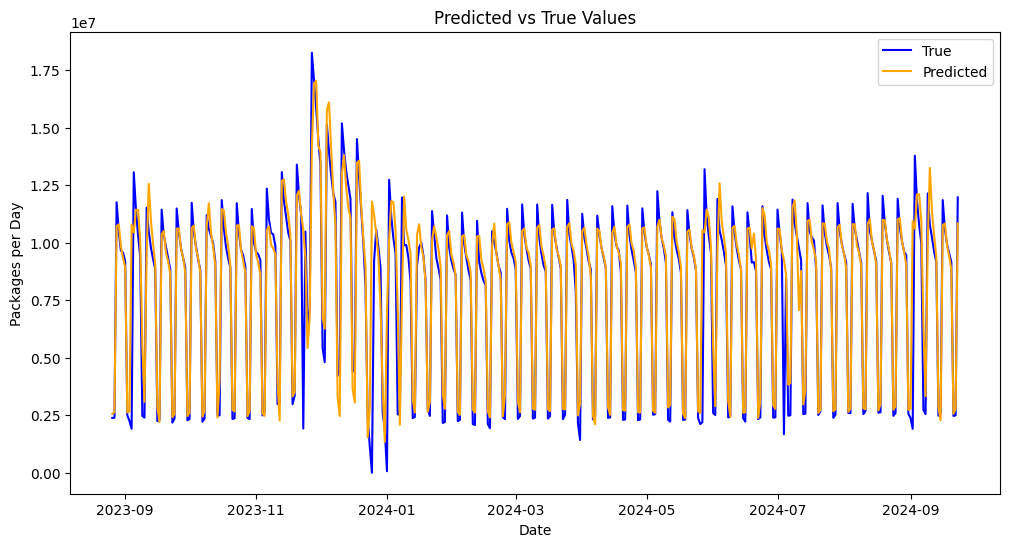

In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from pandas.tseries.holiday import USFederalHolidayCalendar
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 1. Data Preparation
file_path = '/Workspace/Users/cameron.railton@fedex.com/research_project/fxg-finance-ml-field-cost-dock-test/src/databricks/swak_view_cameron_2018 1.csv'

# Step 1: Read the data
input_df = pd.read_csv(file_path)

# Step 2: Convert 'swak_dt' to datetime and extract date
input_df['date'] = pd.to_datetime(input_df['swak_dt']).dt.date

# Step 3: Group by 'date' and aggregate the sum of 'total_pkgs' per day
input_df = input_df.groupby('date').agg(pkgs_perday=('total_pkgs', 'sum')).reset_index()

# Step 4: Sort the result by 'date'
input_df = input_df.sort_values(by='date')

# Step 5: Filter to keep only the rows where the 'date' is between '2018-05-01' and '2024-09-23'
start_date = pd.to_datetime('2018-05-01').date()
end_date = pd.to_datetime('2024-09-23').date()
input_df = input_df[(input_df['date'] <= end_date) & (input_df['date'] >= start_date)]

# Optional: Reset index after filtering
input_df = input_df.reset_index(drop=True)

# Step 6: Ensure continuous date range by filling missing dates with 0 packages
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
input_df = input_df.set_index('date').reindex(all_dates, fill_value=0).rename_axis('date').reset_index()

# Step 7: Feature Engineering
# a. Add day of the week and month
input_df['day_of_week'] = pd.to_datetime(input_df['date']).dt.dayofweek  # 0=Monday, 6=Sunday
input_df['month'] = pd.to_datetime(input_df['date']).dt.month

# b. Add holiday flag (US Federal Holidays)
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date).date
input_df['is_holiday'] = input_df['date'].isin(holidays).astype(int)

# c. Add 7-day lag features
for lag in range(1, 8):
    input_df[f'lag_{lag}'] = input_df['pkgs_perday'].shift(lag)
# Fill NaN values resulting from lagging
input_df.fillna(method='bfill', inplace=True)

# d. Add rolling mean and rolling standard deviation
input_df['rolling_mean_7'] = input_df['pkgs_perday'].rolling(window=7).mean().fillna(method='bfill')
input_df['rolling_std_7'] = input_df['pkgs_perday'].rolling(window=7).std().fillna(method='bfill')

# 2. Feature Scaling with StandardScaler
# Select features to scale
features_to_scale = ['pkgs_perday', 'day_of_week', 'month', 'is_holiday',
                     'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
                     'rolling_mean_7', 'rolling_std_7']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(input_df[features_to_scale])
scaled_feature_names = [f"{feat}_scaled" for feat in features_to_scale]
input_df[scaled_feature_names] = scaled_features

# Save scaling parameters
pkgs_mean = scaler.mean_[0]
pkgs_scale = scaler.scale_[0]

# 3. Creating Sequences for LSTM Input
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  # Assuming the first feature is the target
    return np.array(sequences), np.array(targets)

# Define sequence length
seq_length = 365

# Select scaled features for sequences
sequence_features = input_df[scaled_feature_names].values
X, y = create_sequences(sequence_features, seq_length)

# 4. Train-Test Split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)  # Shape: (batch_size, seq_length, num_features)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(-1)  # Shape: (batch_size, 1)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(-1)  # Shape: (batch_size, 1)

# 5. Define the Enhanced RNN + LSTM Model
class EnhancedRNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3, bidirectional=True):
        super(EnhancedRNN_LSTM, self).__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                             batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_length, hidden_size * num_directions)
        last_time_step = lstm_out[:, -1, :]  # (batch_size, hidden_size * num_directions)
        output = self.fc(last_time_step)  # (batch_size, output_size)
        return output

# Hyperparameters
input_size = len(scaled_feature_names)  # Number of features
hidden_size = 128
output_size = 1
num_layers = 2
dropout = 0.3
bidirectional = True
learning_rate = 0.001
num_epochs = 5

# Initialize the Model, Loss Function, and Optimizer
model = EnhancedRNN_LSTM(input_size, hidden_size, output_size, num_layers, dropout, bidirectional)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# 6. Training the Model with Early Stopping and Gradient Clipping
# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Ideally, use a separate validation set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Early stopping parameters
early_stopping_patience = 50
min_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        
        optimizer.step()
    
    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_output = model(val_X)
            val_loss += criterion(val_output, val_y).item()
    val_loss /= len(val_loader)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f'Early stopping on epoch {epoch + 1}')
        break

# 7. Model Evaluation
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
y_pred = y_pred_tensor.cpu().numpy()

# Inverse transform predictions and actual values
y_test_inv = (y_test_tensor.cpu().numpy() * pkgs_scale) + pkgs_mean
y_pred_inv = (y_pred * pkgs_scale) + pkgs_mean

# Calculate metrics on original scale
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

# Define sMAPE calculation
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

smapef = smape(y_test_inv, y_pred_inv)

print(f'Test MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}, sMAPE: {smapef:.4f}')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(input_df['date'][-len(y_test):], y_test_inv, label='True', color='blue')
plt.plot(input_df['date'][-len(y_test):], y_pred_inv, label='Predicted', color='orange')
plt.title('Predicted vs True Values')
plt.xlabel('Date')
plt.ylabel('Packages per Day')
plt.legend()
plt.show()


Epoch [10/300], Training Loss: 0.4617, Validation Loss: 0.3130
Epoch [20/300], Training Loss: 0.0970, Validation Loss: 0.2130
Epoch [30/300], Training Loss: 0.1194, Validation Loss: 0.1871
Epoch 00035: reducing learning rate of group 0 to 5.0000e-04.
Epoch [40/300], Training Loss: 0.1066, Validation Loss: 0.1951
Epoch 00046: reducing learning rate of group 0 to 2.5000e-04.
Epoch [50/300], Training Loss: 0.0517, Validation Loss: 0.2038
Epoch 00057: reducing learning rate of group 0 to 1.2500e-04.
Epoch [60/300], Training Loss: 0.0771, Validation Loss: 0.2130
Epoch 00068: reducing learning rate of group 0 to 6.2500e-05.
Epoch [70/300], Training Loss: 0.0759, Validation Loss: 0.2379
Early stopping triggered at epoch 74
MSE: 28006712082432.0000, MAE: 3942432.2500, R2: 0.5179, MAPE: 0.0735


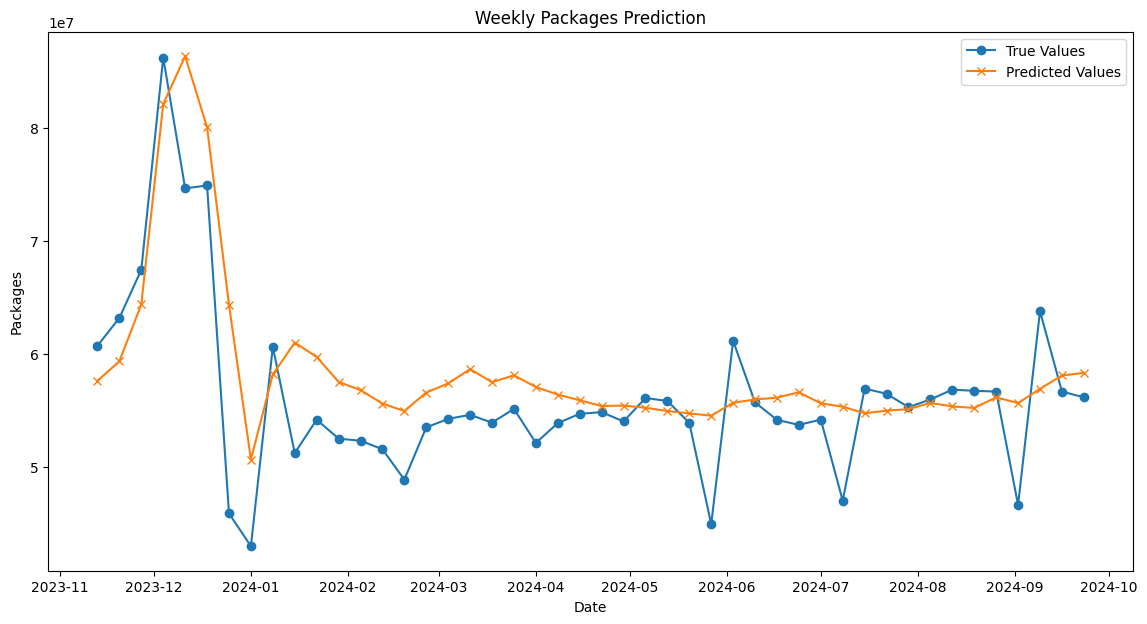

In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from pandas.tseries.holiday import USFederalHolidayCalendar
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 1. Data Preparation
file_path = '/Workspace/Users/cameron.railton@fedex.com/research_project/fxg-finance-ml-field-cost-dock-test/src/databricks/swak_view_cameron_2018 1.csv'

# Step 1: Read the data
input_df = pd.read_csv(file_path)

# Convert 'swak_dt' to datetime
input_df['swak_dt'] = pd.to_datetime(input_df['swak_dt'])

# Group by week and aggregate the sum of 'total_pkgs' per week
input_df = input_df.resample('W-Mon', on='swak_dt').agg(pkgs_perweek=('total_pkgs', 'sum')).reset_index()

# Step 5: Filter to keep only the rows where the 'swak_dt' is between '2018-05-01' and '2024-09-23'
start_date = pd.to_datetime('2018-05-01')
end_date = pd.to_datetime('2024-09-23')
input_df = input_df[(input_df['swak_dt'] <= end_date) & (input_df['swak_dt'] >= start_date)]

# Optional: Reset index after filtering
input_df = input_df.reset_index(drop=True)

# Step 6: Ensure continuous date range by filling missing weeks with 0 packages
all_weeks = pd.date_range(start=start_date, end=end_date, freq='W-Mon')
input_df = input_df.set_index('swak_dt').reindex(all_weeks, fill_value=0).rename_axis('swak_dt').reset_index()

# Step 7: Feature Engineering
# a. Add week of the year
input_df['week_of_year'] = input_df['swak_dt'].dt.isocalendar().week

# b. Add holiday flag (US Federal Holidays)
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date).date
input_df['is_holiday'] = input_df['swak_dt'].dt.date.isin(holidays).astype(int)  # Changed to use dt.date

# c. Add 7-week lag features and additional lag features
for lag in range(1, 15):  # Added lag features up to 14 weeks
    input_df[f'lag_{lag}'] = input_df['pkgs_perweek'].shift(lag)

# Fill NaN values resulting from lagging
input_df.fillna(method='bfill', inplace=True)

# d. Add rolling mean and rolling standard deviation
input_df['rolling_mean_7'] = input_df['pkgs_perweek'].rolling(window=7).mean().fillna(method='bfill')
input_df['rolling_std_7'] = input_df['pkgs_perweek'].rolling(window=7).std().fillna(method='bfill')
input_df['rolling_mean_14'] = input_df['pkgs_perweek'].rolling(window=14).mean().fillna(method='bfill')
input_df['rolling_std_14'] = input_df['pkgs_perweek'].rolling(window=14).std().fillna(method='bfill')

# 2. Feature Scaling with StandardScaler
# Select features to scale
features_to_scale = ['pkgs_perweek', 'week_of_year', 'is_holiday',
                     'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
                     'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
                     'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(input_df[features_to_scale])
scaled_feature_names = [f"{feat}_scaled" for feat in features_to_scale]
input_df[scaled_feature_names] = scaled_features

# Save scaling parameters
pkgs_mean = scaler.mean_[0]
pkgs_scale = scaler.scale_[0]

# 3. Creating Sequences for LSTM Input
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length - 52):  # Predict 52 weeks out
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length + 52, 0])  # Assuming the first feature is the target
    return np.array(sequences), np.array(targets)

# Define sequence length
seq_length = 52  # Now using weeks

# Select scaled features for sequences
sequence_features = input_df[scaled_feature_names].values
X, y = create_sequences(sequence_features, seq_length)

# 4. Train-Test Split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)  # Shape: (batch_size, seq_length, num_features)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(-1)  # Shape: (batch_size, 1)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(-1)  # Shape: (batch_size, 1)

# 5. Define the Enhanced RNN + LSTM Model
class EnhancedRNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3, bidirectional=True):
        super(EnhancedRNN_LSTM, self).__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                             batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_length, hidden_size * num_directions)
        last_time_step = lstm_out[:, -1, :]  # (batch_size, hidden_size * num_directions)
        output = self.fc(last_time_step)  # (batch_size, output_size)
        return output

# Hyperparameters
input_size = len(scaled_feature_names)  # Number of features
hidden_size = 64  # Reduced hidden size
output_size = 1
num_layers = 2
dropout = 0.5  # Increased dropout
bidirectional = True
learning_rate = 0.001
num_epochs = 300

# Initialize the Model, Loss Function, and Optimizer
model = EnhancedRNN_LSTM(input_size, hidden_size, output_size, num_layers, dropout, bidirectional)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# 6. Training the Model with Early Stopping and Gradient Clipping
# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Ideally, use a separate validation set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Early stopping parameters
early_stopping_patience = 50
min_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        
        optimizer.step()
    
    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_output = model(val_X)
            val_loss += criterion(val_output, val_y).item()
    val_loss /= len(val_loader)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
        # Save the model if needed
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Print loss for tracking
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

# 7. Evaluate the Model
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor)
    
# Convert predictions back to original scale
test_output = test_output.cpu().numpy() * pkgs_scale + pkgs_mean
y_test_rescaled = y_test_tensor.cpu().numpy() * pkgs_scale + pkgs_mean

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rescaled, test_output)
mae = mean_absolute_error(y_test_rescaled, test_output)
r2 = r2_score(y_test_rescaled, test_output)
mape = mean_absolute_percentage_error(y_test_rescaled, test_output)

print(f'MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}, MAPE: {mape:.4f}')

# 8. Plotting Results
plt.figure(figsize=(14, 7))
plt.plot(input_df['swak_dt'][-len(y_test_rescaled):], y_test_rescaled, label='True Values', marker='o')
plt.plot(input_df['swak_dt'][-len(test_output):], test_output, label='Predicted Values', marker='x')
plt.title('Weekly Packages Prediction')
plt.xlabel('Date')
plt.ylabel('Packages')
plt.legend()
plt.show()


Epoch [1/300], Train Loss: 0.8415, Val Loss: 0.3225
Epoch [10/300], Train Loss: 0.4324, Val Loss: 0.2682
Epoch [20/300], Train Loss: 0.3028, Val Loss: 0.2345
Epoch [30/300], Train Loss: 0.3072, Val Loss: 0.1945
Epoch [40/300], Train Loss: 0.1191, Val Loss: 0.1733
Epoch [50/300], Train Loss: 0.1270, Val Loss: 0.1501
Epoch [60/300], Train Loss: 0.0920, Val Loss: 0.1505
Epoch 00063: reducing learning rate of group 0 to 5.0000e-04.
Epoch [70/300], Train Loss: 0.0703, Val Loss: 0.1479
Epoch [80/300], Train Loss: 0.0659, Val Loss: 0.1406
Epoch [90/300], Train Loss: 0.0559, Val Loss: 0.1384
Epoch 00100: reducing learning rate of group 0 to 2.5000e-04.
Epoch [100/300], Train Loss: 0.0626, Val Loss: 0.1408
Epoch [110/300], Train Loss: 0.0473, Val Loss: 0.1413
Epoch 00111: reducing learning rate of group 0 to 1.2500e-04.
Epoch [120/300], Train Loss: 0.0472, Val Loss: 0.1418
Epoch 00122: reducing learning rate of group 0 to 6.2500e-05.
Epoch [130/300], Train Loss: 0.0470, Val Loss: 0.1409
Epoch 0

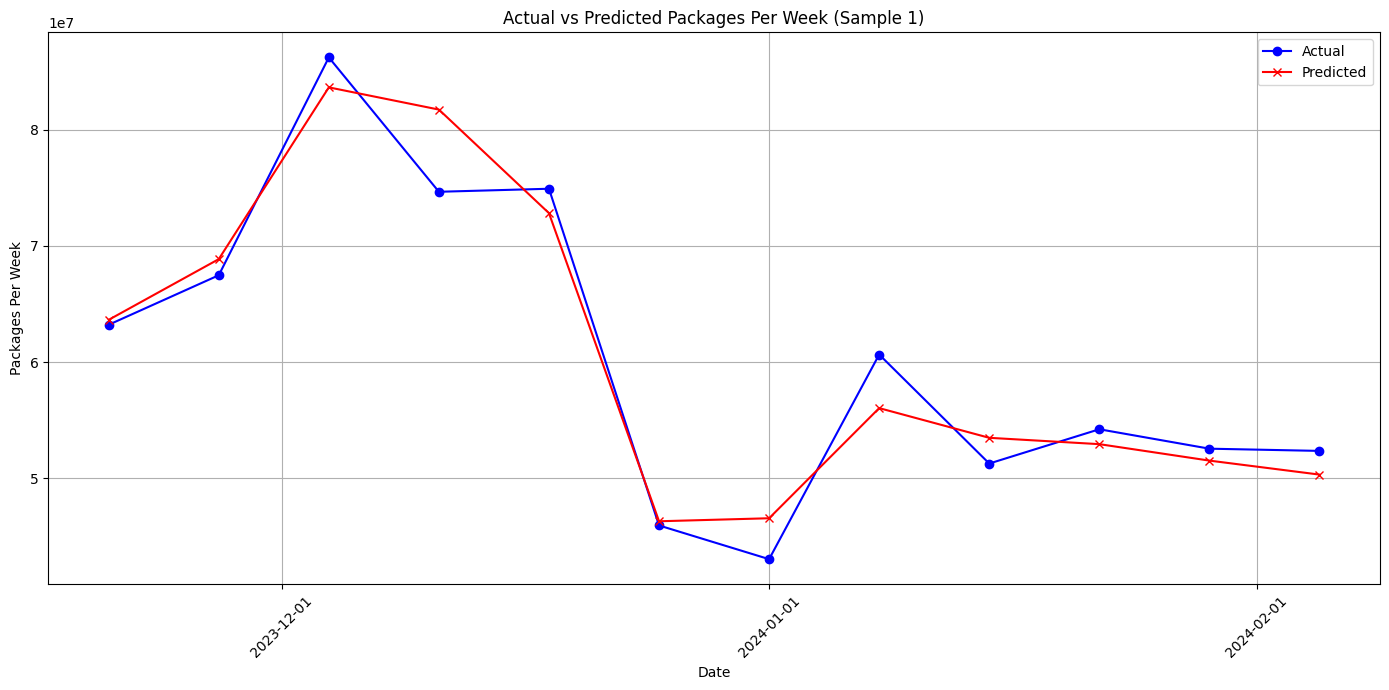


Predictions for the next 12 weeks:
Week 1: 54667706.15 packages
Week 2: 54226746.82 packages
Week 3: 54158479.29 packages
Week 4: 54392676.03 packages
Week 5: 54892361.45 packages
Week 6: 55741554.01 packages
Week 7: 55930408.98 packages
Week 8: 54030443.51 packages
Week 9: 51673036.83 packages
Week 10: 63237267.30 packages
Week 11: 58523284.62 packages
Week 12: 59487791.49 packages


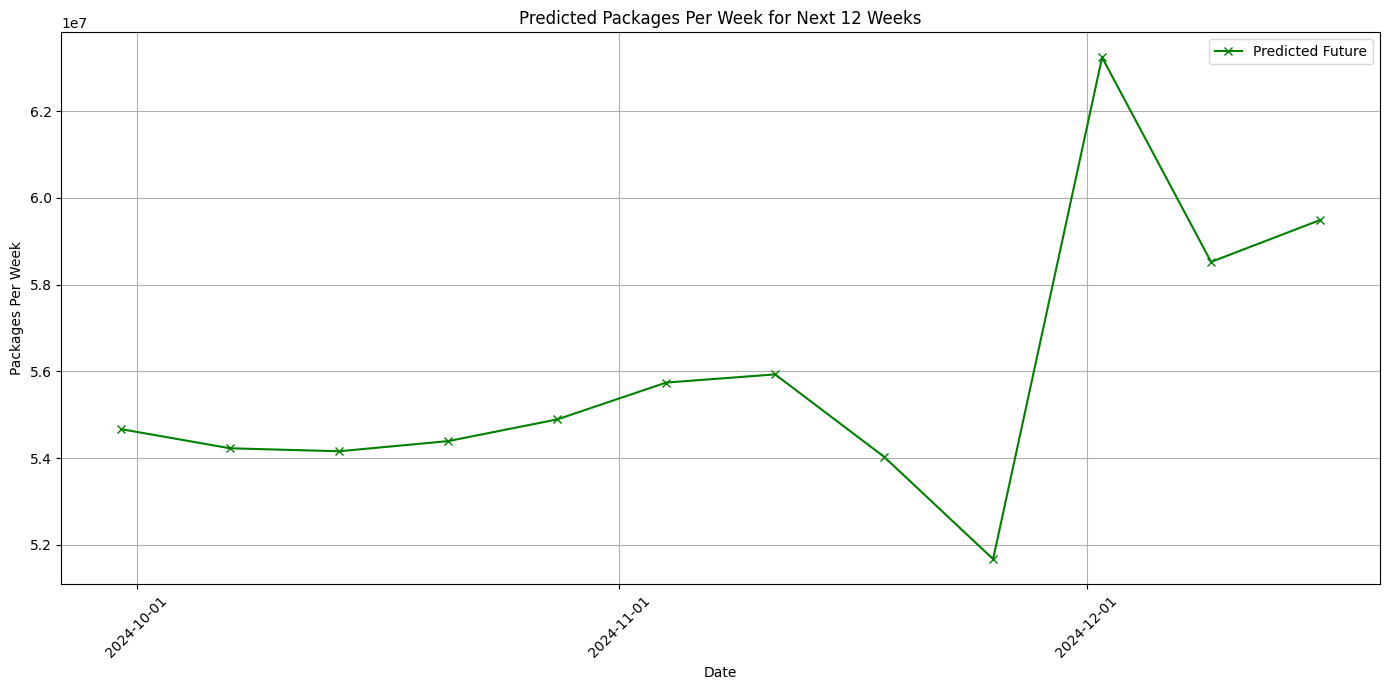

In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from pandas.tseries.holiday import USFederalHolidayCalendar
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.dates as mdates

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# 1. Data Preparation
file_path = '/Workspace/Users/cameron.railton@fedex.com/research_project/fxg-finance-ml-field-cost-dock-test/src/databricks/swak_view_cameron_2018 1.csv'

# Step 1: Read the data
input_df = pd.read_csv(file_path)

# Convert 'swak_dt' to datetime
input_df['swak_dt'] = pd.to_datetime(input_df['swak_dt'])

# Group by week and aggregate the sum of 'total_pkgs' per week
input_df = input_df.resample('W-Mon', on='swak_dt').agg(pkgs_perweek=('total_pkgs', 'sum')).reset_index()

# Step 2: Filter to keep only the rows where the 'swak_dt' is between '2018-05-01' and '2024-09-23'
start_date = pd.to_datetime('2018-05-01')
end_date = pd.to_datetime('2024-09-23')
input_df = input_df[(input_df['swak_dt'] <= end_date) & (input_df['swak_dt'] >= start_date)]

# Optional: Reset index after filtering
input_df = input_df.reset_index(drop=True)

# Step 3: Ensure continuous date range by filling missing weeks with 0 packages
all_weeks = pd.date_range(start=start_date, end=end_date, freq='W-Mon')
input_df = input_df.set_index('swak_dt').reindex(all_weeks, fill_value=0).rename_axis('swak_dt').reset_index()

# Step 4: Feature Engineering
# a. Add week of the year
input_df['week_of_year'] = input_df['swak_dt'].dt.isocalendar().week

# b. Add holiday flag (US Federal Holidays)
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=start_date, end=end_date).date
input_df['is_holiday'] = input_df['swak_dt'].dt.date.isin(holidays).astype(int)

# c. Add 14-week lag features
for lag in range(1, 15):
    input_df[f'lag_{lag}'] = input_df['pkgs_perweek'].shift(lag)

# Fill NaN values resulting from lagging
input_df.fillna(method='bfill', inplace=True)

# d. Add rolling mean and rolling standard deviation
input_df['rolling_mean_7'] = input_df['pkgs_perweek'].rolling(window=7).mean().fillna(method='bfill')
input_df['rolling_std_7'] = input_df['pkgs_perweek'].rolling(window=7).std().fillna(method='bfill')
input_df['rolling_mean_14'] = input_df['pkgs_perweek'].rolling(window=14).mean().fillna(method='bfill')
input_df['rolling_std_14'] = input_df['pkgs_perweek'].rolling(window=14).std().fillna(method='bfill')

# 2. Feature Scaling with StandardScaler
# Select features to scale
features_to_scale = ['pkgs_perweek', 'week_of_year', 'is_holiday',
                     'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
                     'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
                     'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(input_df[features_to_scale])
scaled_feature_names = [f"{feat}_scaled" for feat in features_to_scale]
input_df[scaled_feature_names] = scaled_features

# Save scaling parameters for 'pkgs_perweek'
pkgs_mean = scaler.mean_[0]
pkgs_scale = scaler.scale_[0]

# 3. Creating Sequences for LSTM Input
def create_sequences(data, seq_length, pred_length=12):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length - pred_length + 1):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length:i + seq_length + pred_length, 0])  # Assuming the first feature is the target
    return np.array(sequences), np.array(targets)

# Define sequence length and prediction length
seq_length = 156  # Using 52 weeks of data
pred_length = 12  # Predicting 12 weeks ahead

# Select scaled features for sequences
sequence_features = input_df[scaled_feature_names].values
X, y = create_sequences(sequence_features, seq_length, pred_length)

# 4. Train-Test Split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)  # Shape: (batch_size, seq_length, num_features)
y_train_tensor = torch.FloatTensor(y_train)  # Shape: (batch_size, pred_length)

X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)  # Shape: (batch_size, pred_length)

# 5. Define the Enhanced RNN + LSTM Model
class EnhancedRNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3, bidirectional=True):
        super(EnhancedRNN_LSTM, self).__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_length, hidden_size * num_directions)
        last_time_step = lstm_out[:, -1, :]  # (batch_size, hidden_size * num_directions)
        output = self.fc(last_time_step)  # (batch_size, output_size)
        return output

# Hyperparameters
input_size = len(scaled_feature_names)  # Number of features
hidden_size = 256  # Hidden layer size
output_size = pred_length  # Output size for predicting 12 weeks ahead
num_layers = 3
dropout = 0.1  # Dropout rate
bidirectional = True
learning_rate = 0.001
num_epochs = 300
# Best Parameters: Hidden Size: 256, Layers: 3, Dropout: 0.1 with Val Loss: 0.4750
# Initialize the Model, Loss Function, and Optimizer
model = EnhancedRNN_LSTM(input_size, hidden_size, output_size, num_layers, dropout, bidirectional)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# 6. Training the Model with Early Stopping and Gradient Clipping
# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Early stopping parameters
early_stopping_patience = 50
min_val_loss = float('inf')
patience_counter = 0

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation step
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_output = model(val_X)
            loss = criterion(val_output, val_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    # Adjust learning rate
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break
    
    # Print training and validation loss for each epoch
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# 7. Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# 8. Evaluate the model on the test set
with torch.no_grad():
    y_test_pred = model(X_test_tensor).cpu().numpy()  # Shape: (batch_size, pred_length)
    y_test_actual = y_test_tensor.cpu().numpy()  # Shape: (batch_size, pred_length)

# 9. Inverse scaling for predictions and actual values
def inverse_transform_predictions(predictions, scaler, scaled_feature_names):
    """
    Inverse transform the predictions using the scaler.
    
    Args:
        predictions (np.ndarray): Scaled predictions (batch_size, pred_length).
        scaler (StandardScaler): Fitted scaler.
        scaled_feature_names (list): List of scaled feature names.
    
    Returns:
        np.ndarray: Inverse transformed predictions (batch_size, pred_length).
    """
    num_predictions = predictions.shape[1]
    inverse_preds = []
    for i in range(num_predictions):
        # Create an array where only the first feature is the prediction, others are zeros
        temp = np.zeros((predictions.shape[0], len(scaled_feature_names)))
        temp[:, 0] = predictions[:, i]
        # Inverse transform
        inverse_scaled = scaler.inverse_transform(temp)
        # Extract the first column (pkgs_perweek)
        inverse_preds.append(inverse_scaled[:, 0])
    return np.array(inverse_preds).T  # Shape: (batch_size, pred_length)

# Inverse transform predictions and actuals
predictions_inverse = inverse_transform_predictions(y_test_pred, scaler, scaled_feature_names)
actuals_inverse = inverse_transform_predictions(y_test_actual, scaler, scaled_feature_names)

# 10. Calculate and print evaluation metrics
mse = mean_squared_error(actuals_inverse, predictions_inverse)
mae = mean_absolute_error(actuals_inverse, predictions_inverse)
r2 = r2_score(actuals_inverse, predictions_inverse)
mape = mean_absolute_percentage_error(actuals_inverse, predictions_inverse)

print(f'\nEvaluation Metrics on Test Set:')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'R² Score: {r2:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# 11. Plotting Predictions vs Actuals for Test Set
# Select a single sample to plot
sample_idx = 0  # You can change this index to plot different samples

# Ensure the sample index is within the range
if sample_idx >= len(predictions_inverse):
    sample_idx = len(predictions_inverse) - 1

# Get the corresponding dates for the test set predictions
test_start_idx = train_size + seq_length
test_end_idx = test_start_idx + pred_length
test_dates = input_df['swak_dt'].iloc[test_start_idx : test_start_idx + pred_length].values

# Extract the actual and predicted values for the selected sample
actual_sequence = actuals_inverse[sample_idx]
predicted_sequence = predictions_inverse[sample_idx]

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(test_dates, actual_sequence, label='Actual', color='blue', marker='o')
plt.plot(test_dates, predicted_sequence, label='Predicted', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Packages Per Week')
plt.title('Actual vs Predicted Packages Per Week (Sample {})'.format(sample_idx + 1))
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.grid()
plt.tight_layout()
plt.show()

# 12. Function to Predict Future 12 Weeks
def predict_future(model, initial_sequence, num_steps, scaler, scaled_feature_names):
    """
    Predict future packages for the next `num_steps` weeks based on the initial_sequence.
    
    Args:
        model (nn.Module): Trained LSTM model.
        initial_sequence (np.ndarray): Initial sequence of shape (seq_length, num_features).
        num_steps (int): Number of weeks to predict.
        scaler (StandardScaler): Fitted scaler.
        scaled_feature_names (list): List of scaled feature names.
    
    Returns:
        np.ndarray: Predicted package counts for the next `num_steps` weeks.
    """
    model.eval()
    predictions = []
    input_sequence = torch.FloatTensor(initial_sequence).unsqueeze(0).to(device)  # Shape: (1, seq_length, num_features)
    
    for _ in range(num_steps):
        with torch.no_grad():
            pred = model(input_sequence).cpu().numpy()  # Shape: (1, pred_length)
        
        # Take the first prediction (Week 1)
        next_pred_scaled = pred[0, 0]
        predictions.append(next_pred_scaled)
        
        # Prepare the next input sequence
        # Shift the sequence left by one week
        new_input = input_sequence.cpu().numpy().copy()
        new_input = np.roll(new_input, -1, axis=1)
        # Update the last week with the new prediction for 'pkgs_perweek_scaled'
        new_input[0, -1, 0] = next_pred_scaled  # Assuming 'pkgs_perweek_scaled' is the first feature
        # Convert back to tensor
        input_sequence = torch.FloatTensor(new_input).to(device)
    
    # Inverse transform the predictions
    predictions_array = np.array(predictions).reshape(-1, 1)
    predictions_inverse = inverse_transform_predictions(predictions_array, scaler, scaled_feature_names)
    
    return predictions_inverse.flatten()

# 13. Make Future Predictions
# Use the last sequence from the test set as the initial sequence
initial_sequence = X_test[-1]  # Shape: (seq_length, num_features)

# Number of weeks to predict
num_weeks_to_predict = 12

# Generate predictions for the next 12 weeks
future_predictions = predict_future(model, initial_sequence, num_weeks_to_predict, scaler, scaled_feature_names)

# Print the predictions
print("\nPredictions for the next 12 weeks:")
for i, pred in enumerate(future_predictions, 1):
    print(f"Week {i}: {pred:.2f} packages")

# 14. Plot Future Predictions
# Create future dates
last_date = input_df['swak_dt'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=num_weeks_to_predict, freq='W-Mon')

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(future_dates, future_predictions, label='Predicted Future', color='green', marker='x')
plt.xlabel('Date')
plt.ylabel('Packages Per Week')
plt.title('Predicted Packages Per Week for Next 12 Weeks')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.grid()
plt.tight_layout()
plt.show()


In [0]:
# Function to calculate sMAPE
def smape(actual, predicted):
    """
    Calculate Symmetric Mean Absolute Percentage Error (sMAPE).
    
    Args:
        actual (np.ndarray): Actual values.
        predicted (np.ndarray): Predicted values.
    
    Returns:
        float: sMAPE value.
    """
    actual, predicted = np.array(actual), np.array(predicted)
    denominator = np.abs(actual) + np.abs(predicted)
    diff = np.abs(actual - predicted) / denominator
    # Avoid division by zero
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)
# Calculate and print sMAPE
smap_e = smape(actual_sequence, future_predictions)
print(f"\nsMAPE for the next 12 weeks: {smap_e:.2f}%")



sMAPE for the next 12 weeks: 20.07%


In [0]:
# Best Parameters: Hidden Size: 256, Layers: 3, Dropout: 0.1 with Val Loss: 0.4750